In [42]:
# Importar as bibliotecas necessárias
import os
import time
import numpy as np
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchmetrics
from torchvision.transforms import functional as F
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt

# Verificar se CUDA está disponível e definir o dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando o dispositivo: {device}")

# Definir as cores para as classes
CLASS_COLORS = { 
    'Doenca': (255, 0, 0), 
    'Saudavel': (0, 255, 0), 
    'Solo': (0, 0, 255) 
}

Usando o dispositivo: cuda


In [43]:
# Classe do Dataset personalizado
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        # Modificar a extensão da máscara para '.png'
        mask_name = os.path.splitext(img_name)[0] + '.png'
        mask_path = os.path.join(self.mask_dir, mask_name)
        
        # Carregar a imagem e a máscara
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")
        
        if self.transform:
            # Aplicar transformações, se houver
            image = self.transform(image)
            mask = self.transform(mask)
            
        # Convertemos as máscaras de imagem em um array de índices de classe
        mask = self.mask_to_class(mask)
        
        return image, mask
    
    def mask_to_class(self, mask):
        # Converte a máscara para um array NumPy e ajusta para escala de 0 a 255
        mask_array = (np.array(mask, dtype=np.float32) * 255).astype(np.uint8)

        # Garantir que esté em [H, W, C]
        if mask_array.shape[0] == 3:
            mask_array = mask_array.transpose(1, 2, 0)

        mask_indices = np.zeros((mask_array.shape[0], mask_array.shape[1]), dtype=np.int64)

        for i, color in enumerate(CLASS_COLORS.values()):
            # Realizar comparação e detecção de igualdade entre pixels
            equal_color = np.all(mask_array == color, axis=-1)
            mask_indices[equal_color] = i

        return torch.tensor(mask_indices, dtype=torch.long)

# Testar a primeira amostra do dataset para verificar as classes convertidas da máscara
image, mask = sample_dataset[0]

# Outras inicializações de datasets e dataloaders
train_dataset = SegmentationDataset(
    image_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/base/Train",
    mask_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/masks/Train",
    transform=get_transforms()
)

val_dataset = SegmentationDataset(
    image_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/base/Val",
    mask_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/masks/Val",
    transform=get_transforms()
)

test_dataset = SegmentationDataset(
    image_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/base/Test",
    mask_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/masks/Test",
    transform=get_transforms()
)

# Criar os DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print("Dados carregados e preparados.")

Valores únicos nas máscaras logo após carregar: [[  0   0   0]
 [  0   0   1]
 [  0   0   2]
 ...
 [253   0   0]
 [254   0   0]
 [255   0   0]]
Checando para cor RGB: (255, 0, 0)
Pixels identificados como (255, 0, 0): 5134
Checando para cor RGB: (0, 255, 0)
Pixels identificados como (0, 255, 0): 11529
Checando para cor RGB: (0, 0, 255)
Pixels identificados como (0, 0, 255): 22063
Classes únicas encontradas após conversão: [0 1 2]
Dados carregados e preparados.


In [44]:
# Importar a biblioteca segmentation-models-pytorch
!pip install segmentation-models-pytorch --quiet

import segmentation_models_pytorch as smp

# Inicializar as arquiteturas dos modelos com os pesos pretreinados por padrão
unet = smp.Unet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=len(CLASS_COLORS)).to(device)
pspnet = smp.PSPNet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=len(CLASS_COLORS)).to(device)
linknet = smp.Linknet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=len(CLASS_COLORS)).to(device)
deeplabv3 = smp.DeepLabV3(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=len(CLASS_COLORS)).to(device)

models = {
    'U-Net': unet,
    'PSPNet': pspnet,
    'LinkNet': linknet,
    'DeepLabV3': deeplabv3
}

print("Modelos configurados e prontos para treinamento.")

Modelos configurados e prontos para treinamento.


In [45]:
import csv
import time
import os

# Diretório para salvar os resultados
results_dir = "E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/results/data"
os.makedirs(results_dir, exist_ok=True)

def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, metrics, num_epochs, device, patience, model_name, results_dir):
    since = time.time()
    best_model_wts = model.state_dict()
    best_loss = float('inf')
    patience_counter = 0

    # Variáveis para armazenar tempos de execução
    training_time = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        epoch_start = time.time()  # Marcar o início da época

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                data_loader = train_loader
            else:
                model.eval()
                data_loader = val_loader

            running_loss = 0.0
            running_metrics = {key: 0 for key in metrics.keys()}
            
            for inputs, masks in tqdm(data_loader):
                inputs, masks = inputs.to(device), masks.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, masks)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

                for metric_name, metric in metrics.items():
                    running_metrics[metric_name] += metric(preds, masks).item() * inputs.size(0)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_metrics = {key: value / len(data_loader.dataset) for key, value in running_metrics.items()}

            print(f'{phase} Loss: {epoch_loss:.4f}')
            for metric_name in metrics:
                print(f'{phase} {metric_name}: {epoch_metrics[metric_name]:.4f}')

            if phase == 'val':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = model.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1

        epoch_end = time.time()  # Marcar o fim da época
        epoch_time = epoch_end - epoch_start
        training_time += epoch_time  # Acumular tempos totais
        print(f'Epoch time: {epoch_time:.2f} seconds')

        print(f'Patience counter: {patience_counter}')

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val loss: {best_loss:.4f}')

    # Optimizador única vez
    model.load_state_dict(best_model_wts)

    # Salvar o modelo treinado
    model_path = os.path.join(results_dir, f'{model_name}_best.pth')
    torch.save(model.state_dict(), model_path)

    # Coletar as métricas finais
    final_metrics = epoch_metrics
    final_metrics['best_loss'] = best_loss
    final_metrics['training_time'] = time_elapsed

    # Salvar todas as métricas para CSV
    csv_path = os.path.join(results_dir, 'results.csv')
    write_metrics_to_csv(csv_path, model_name, final_metrics)

    return model

def write_metrics_to_csv(csv_path, model_name, metrics):
    headers = ['nome', 'f1-score', 'indice jaccard', 'precision', 'best_loss', 'training_time']
    row = [
        model_name,
        metrics['F1'],
        metrics['Jaccard'],
        metrics['Precision'],
        metrics['best_loss'],
        metrics['training_time']
    ]

    file_exists = os.path.isfile(csv_path)

    with open(csv_path, mode='a', newline='') as f:
        writer = csv.writer(f)
        if not file_exists:
            writer.writerow(headers)  # Escrever cabeçalhos se o arquivo não existe
        writer.writerow(row)  # Salvar linha de métricas

# Definir um otimizador para cada modelo
optimizers = {
    model_name: torch.optim.Adam(model.parameters(), lr=learning_rate) 
    for model_name, model in models.items()
}

# Executar o Treinamento dos Modelos
for model_name, model in models.items():
    print("*********************************************************************")
    print(f"Treinando {model_name} com early stopping...")
    trained_model = train_model_with_early_stopping(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizers[model_name],
        metrics=metrics,
        num_epochs=num_epochs,
        device=device,
        patience=patience,
        model_name=model_name,
        results_dir=results_dir
    )
    print(f'{model_name} treinado e salvo com sucesso.')

print("Treinamento completo de todos os modelos com early stopping.")

Treinando U-Net com early stopping...
Epoch 1/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


train Loss: 0.8609
train F1: 0.5364
train Jaccard: 0.3990
train Precision: 0.5552


100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


val Loss: 0.9699
val F1: 0.5327
val Jaccard: 0.3887
val Precision: 0.5417
Epoch time: 24.41 seconds
Patience counter: 0
Epoch 2/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


train Loss: 0.6310
train F1: 0.6382
train Jaccard: 0.5084
train Precision: 0.6941


100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


val Loss: 0.6112
val F1: 0.6520
val Jaccard: 0.5199
val Precision: 0.6888
Epoch time: 24.33 seconds
Patience counter: 0
Epoch 3/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


train Loss: 0.5740
train F1: 0.6961
train Jaccard: 0.5556
train Precision: 0.7161


100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


val Loss: 0.6068
val F1: 0.6325
val Jaccard: 0.4951
val Precision: 0.6744
Epoch time: 24.09 seconds
Patience counter: 0
Epoch 4/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


train Loss: 0.5101
train F1: 0.7244
train Jaccard: 0.5920
train Precision: 0.7469


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


val Loss: 0.4521
val F1: 0.6968
val Jaccard: 0.5856
val Precision: 0.7398
Epoch time: 24.25 seconds
Patience counter: 0
Epoch 5/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


train Loss: 0.4462
train F1: 0.7785
train Jaccard: 0.6530
train Precision: 0.7723


100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


val Loss: 0.5592
val F1: 0.6404
val Jaccard: 0.5214
val Precision: 0.6701
Epoch time: 23.92 seconds
Patience counter: 1
Epoch 6/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


train Loss: 0.4664
train F1: 0.7666
train Jaccard: 0.6392
train Precision: 0.7801


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


val Loss: 0.7614
val F1: 0.5311
val Jaccard: 0.4490
val Precision: 0.6618
Epoch time: 24.11 seconds
Patience counter: 2
Epoch 7/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.25it/s]


train Loss: 0.4527
train F1: 0.7721
train Jaccard: 0.6465
train Precision: 0.7818


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


val Loss: 0.4670
val F1: 0.6883
val Jaccard: 0.5686
val Precision: 0.7012
Epoch time: 24.00 seconds
Patience counter: 3
Epoch 8/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


train Loss: 0.3776
train F1: 0.8262
train Jaccard: 0.7155
train Precision: 0.8324


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


val Loss: 0.4381
val F1: 0.6951
val Jaccard: 0.5881
val Precision: 0.7261
Epoch time: 24.31 seconds
Patience counter: 0
Epoch 9/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


train Loss: 0.3786
train F1: 0.8238
train Jaccard: 0.7119
train Precision: 0.8204


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


val Loss: 0.8197
val F1: 0.6102
val Jaccard: 0.4640
val Precision: 0.6135
Epoch time: 24.16 seconds
Patience counter: 1
Epoch 10/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


train Loss: 0.3740
train F1: 0.8141
train Jaccard: 0.7035
train Precision: 0.8156


100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


val Loss: 0.4355
val F1: 0.6934
val Jaccard: 0.5860
val Precision: 0.7342
Epoch time: 24.43 seconds
Patience counter: 0
Training complete in 4m 2s
Best val loss: 0.4355
U-Net treinado e salvo com sucesso.
Treinando PSPNet com early stopping...
Epoch 1/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


train Loss: 0.8697
train F1: 0.5816
train Jaccard: 0.4386
train Precision: 0.6506


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


val Loss: 3.8128
val F1: 0.3403
val Jaccard: 0.2500
val Precision: 0.4994
Epoch time: 24.11 seconds
Patience counter: 0
Epoch 2/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


train Loss: 0.6829
train F1: 0.6399
train Jaccard: 0.5023
train Precision: 0.6579


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


val Loss: 1.1952
val F1: 0.4943
val Jaccard: 0.3549
val Precision: 0.5925
Epoch time: 24.09 seconds
Patience counter: 0
Epoch 3/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


train Loss: 0.5154
train F1: 0.7241
train Jaccard: 0.5924
train Precision: 0.7506


100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


val Loss: 0.7008
val F1: 0.6279
val Jaccard: 0.4850
val Precision: 0.6643
Epoch time: 23.98 seconds
Patience counter: 0
Epoch 4/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


train Loss: 0.4749
train F1: 0.7414
train Jaccard: 0.6181
train Precision: 0.7678


100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


val Loss: 0.5114
val F1: 0.6917
val Jaccard: 0.5697
val Precision: 0.7266
Epoch time: 23.92 seconds
Patience counter: 0
Epoch 5/10
----------


100%|██████████| 20/20 [00:15<00:00,  1.25it/s]


train Loss: 0.4766
train F1: 0.7543
train Jaccard: 0.6287
train Precision: 0.7880


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


val Loss: 0.4360
val F1: 0.7162
val Jaccard: 0.6040
val Precision: 0.7572
Epoch time: 24.01 seconds
Patience counter: 0
Epoch 6/10
----------


100%|██████████| 20/20 [00:15<00:00,  1.25it/s]


train Loss: 0.4356
train F1: 0.7889
train Jaccard: 0.6668
train Precision: 0.8038


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


val Loss: 0.7393
val F1: 0.6597
val Jaccard: 0.5233
val Precision: 0.7152
Epoch time: 23.99 seconds
Patience counter: 1
Epoch 7/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.25it/s]


train Loss: 0.3789
train F1: 0.8094
train Jaccard: 0.6916
train Precision: 0.8280


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


val Loss: 0.4737
val F1: 0.6996
val Jaccard: 0.5939
val Precision: 0.7197
Epoch time: 24.01 seconds
Patience counter: 2
Epoch 8/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


train Loss: 0.3971
train F1: 0.8131
train Jaccard: 0.6961
train Precision: 0.8155


100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


val Loss: 0.7876
val F1: 0.6121
val Jaccard: 0.5178
val Precision: 0.7000
Epoch time: 24.37 seconds
Patience counter: 3
Epoch 9/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.25it/s]


train Loss: 0.3118
train F1: 0.8513
train Jaccard: 0.7473
train Precision: 0.8520


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


val Loss: 0.4419
val F1: 0.7289
val Jaccard: 0.6200
val Precision: 0.7535
Epoch time: 23.90 seconds
Patience counter: 4
Epoch 10/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


train Loss: 0.2862
train F1: 0.8663
train Jaccard: 0.7703
train Precision: 0.8685


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


val Loss: 0.5462
val F1: 0.7193
val Jaccard: 0.6121
val Precision: 0.7561
Epoch time: 24.38 seconds
Patience counter: 5
Training complete in 4m 1s
Best val loss: 0.4360
PSPNet treinado e salvo com sucesso.
Treinando LinkNet com early stopping...
Epoch 1/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


train Loss: 0.9211
train F1: 0.4776
train Jaccard: 0.3534
train Precision: 0.5257


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


val Loss: 0.8169
val F1: 0.4283
val Jaccard: 0.3259
val Precision: 0.4508
Epoch time: 24.67 seconds
Patience counter: 0
Epoch 2/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


train Loss: 0.6050
train F1: 0.5944
train Jaccard: 0.4966
train Precision: 0.6753


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


val Loss: 2.2529
val F1: 0.4355
val Jaccard: 0.3294
val Precision: 0.5347
Epoch time: 24.65 seconds
Patience counter: 1
Epoch 3/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


train Loss: 0.5464
train F1: 0.6594
train Jaccard: 0.5465
train Precision: 0.7126


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


val Loss: 0.4967
val F1: 0.6287
val Jaccard: 0.5371
val Precision: 0.7027
Epoch time: 24.51 seconds
Patience counter: 0
Epoch 4/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


train Loss: 0.5262
train F1: 0.6666
train Jaccard: 0.5520
train Precision: 0.7318


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


val Loss: 0.4802
val F1: 0.6796
val Jaccard: 0.5673
val Precision: 0.7204
Epoch time: 24.30 seconds
Patience counter: 0
Epoch 5/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


train Loss: 0.4614
train F1: 0.7517
train Jaccard: 0.6308
train Precision: 0.7738


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


val Loss: 0.6141
val F1: 0.5954
val Jaccard: 0.4723
val Precision: 0.6475
Epoch time: 24.38 seconds
Patience counter: 1
Epoch 6/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


train Loss: 0.4524
train F1: 0.7653
train Jaccard: 0.6459
train Precision: 0.7896


100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


val Loss: 0.5663
val F1: 0.5703
val Jaccard: 0.4652
val Precision: 0.6689
Epoch time: 24.27 seconds
Patience counter: 2
Epoch 7/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


train Loss: 0.4091
train F1: 0.8014
train Jaccard: 0.6864
train Precision: 0.7996


100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


val Loss: 0.4423
val F1: 0.6502
val Jaccard: 0.5569
val Precision: 0.7180
Epoch time: 24.20 seconds
Patience counter: 0
Epoch 8/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


train Loss: 0.3789
train F1: 0.8239
train Jaccard: 0.7158
train Precision: 0.8263


100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


val Loss: 0.5765
val F1: 0.6853
val Jaccard: 0.5587
val Precision: 0.7174
Epoch time: 24.22 seconds
Patience counter: 1
Epoch 9/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.25it/s]


train Loss: 0.3532
train F1: 0.8367
train Jaccard: 0.7329
train Precision: 0.8384


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


val Loss: 0.5164
val F1: 0.6660
val Jaccard: 0.5632
val Precision: 0.7301
Epoch time: 24.11 seconds
Patience counter: 2
Epoch 10/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


train Loss: 0.3294
train F1: 0.8521
train Jaccard: 0.7518
train Precision: 0.8520


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


val Loss: 0.5897
val F1: 0.7101
val Jaccard: 0.5937
val Precision: 0.7339
Epoch time: 24.15 seconds
Patience counter: 3
Training complete in 4m 3s
Best val loss: 0.4423
LinkNet treinado e salvo com sucesso.
Treinando DeepLabV3 com early stopping...
Epoch 1/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


train Loss: 1.0494
train F1: 0.4622
train Jaccard: 0.3159
train Precision: 0.5069


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


val Loss: 1.4968
val F1: 0.3634
val Jaccard: 0.2450
val Precision: 0.4709
Epoch time: 24.88 seconds
Patience counter: 0
Epoch 2/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


train Loss: 0.7537
train F1: 0.6049
train Jaccard: 0.4528
train Precision: 0.6413


100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


val Loss: 0.7832
val F1: 0.5317
val Jaccard: 0.3941
val Precision: 0.5623
Epoch time: 25.29 seconds
Patience counter: 0
Epoch 3/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


train Loss: 0.6753
train F1: 0.6556
train Jaccard: 0.5051
train Precision: 0.6769


100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


val Loss: 0.7112
val F1: 0.6041
val Jaccard: 0.4694
val Precision: 0.6573
Epoch time: 25.46 seconds
Patience counter: 0
Epoch 4/10
----------


100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


train Loss: 0.5550
train F1: 0.7130
train Jaccard: 0.5738
train Precision: 0.7396


100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


val Loss: 0.9300
val F1: 0.5268
val Jaccard: 0.4008
val Precision: 0.5753
Epoch time: 26.22 seconds
Patience counter: 1
Epoch 5/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


train Loss: 0.4898
train F1: 0.7697
train Jaccard: 0.6355
train Precision: 0.7621


100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


val Loss: 0.7743
val F1: 0.5151
val Jaccard: 0.4095
val Precision: 0.5939
Epoch time: 24.68 seconds
Patience counter: 2
Epoch 6/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


train Loss: 0.4482
train F1: 0.7837
train Jaccard: 0.6565
train Precision: 0.7914


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


val Loss: 0.7666
val F1: 0.5360
val Jaccard: 0.4205
val Precision: 0.5561
Epoch time: 24.59 seconds
Patience counter: 3
Epoch 7/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


train Loss: 0.4192
train F1: 0.8081
train Jaccard: 0.6881
train Precision: 0.8040


100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


val Loss: 0.5863
val F1: 0.6846
val Jaccard: 0.5588
val Precision: 0.6944
Epoch time: 24.42 seconds
Patience counter: 0
Epoch 8/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.25it/s]


train Loss: 0.3448
train F1: 0.8386
train Jaccard: 0.7308
train Precision: 0.8355


100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


val Loss: 0.4808
val F1: 0.7240
val Jaccard: 0.6027
val Precision: 0.7507
Epoch time: 24.03 seconds
Patience counter: 0
Epoch 9/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


train Loss: 0.3720
train F1: 0.8293
train Jaccard: 0.7208
train Precision: 0.8234


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


val Loss: 0.6878
val F1: 0.6608
val Jaccard: 0.5242
val Precision: 0.6950
Epoch time: 24.48 seconds
Patience counter: 1
Epoch 10/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


train Loss: 0.3409
train F1: 0.8499
train Jaccard: 0.7446
train Precision: 0.8471


100%|██████████| 10/10 [00:07<00:00,  1.28it/s]

val Loss: 0.5382
val F1: 0.7039
val Jaccard: 0.5795
val Precision: 0.7220
Epoch time: 24.36 seconds
Patience counter: 2
Training complete in 4m 8s
Best val loss: 0.4808
DeepLabV3 treinado e salvo com sucesso.
Treinamento completo de todos os modelos com early stopping.


Visualizando e salvando predições para U-Net...


C:\Users\Henrique Moreira\AppData\Local\Temp\ipykernel_12208\2253927742.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load(trained

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


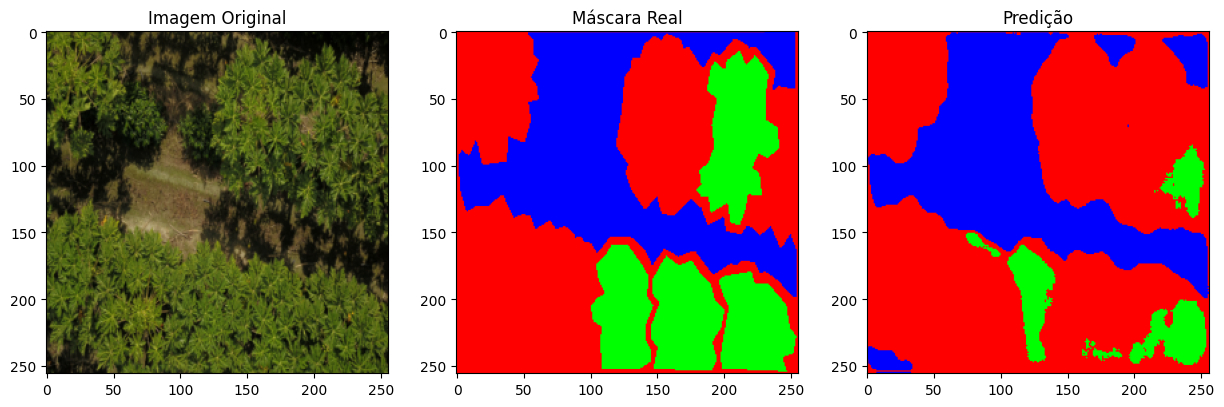

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


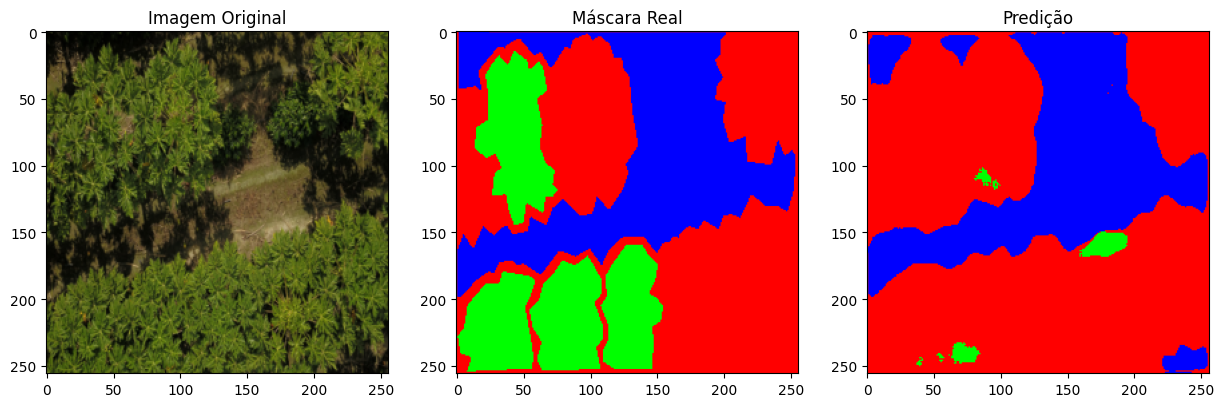

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


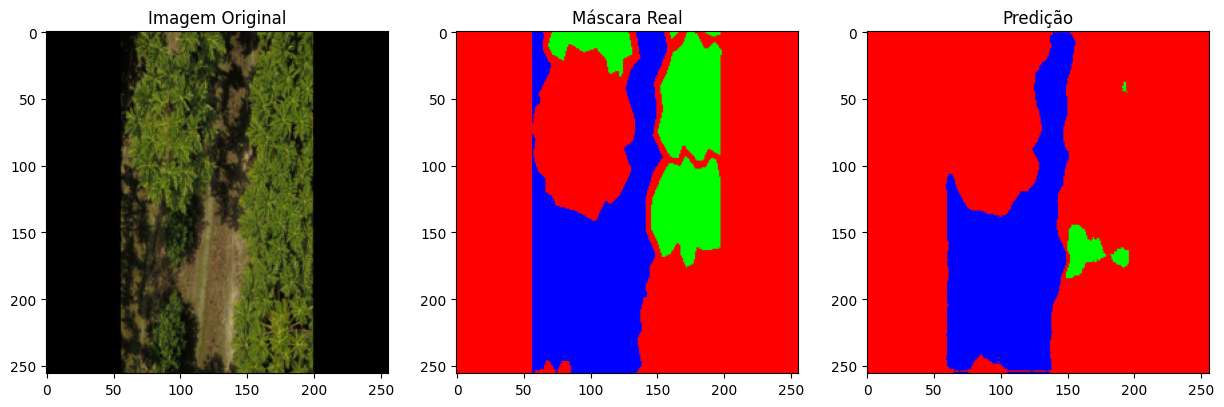

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


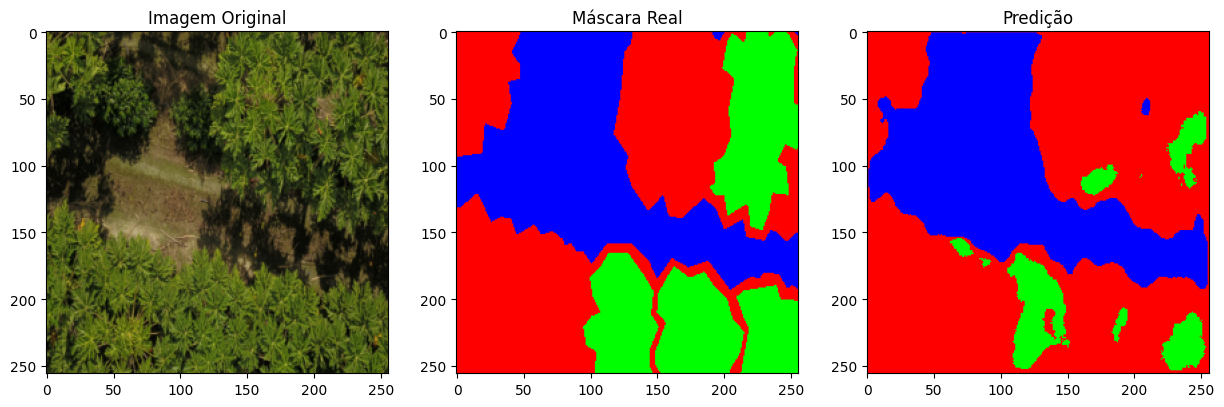

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


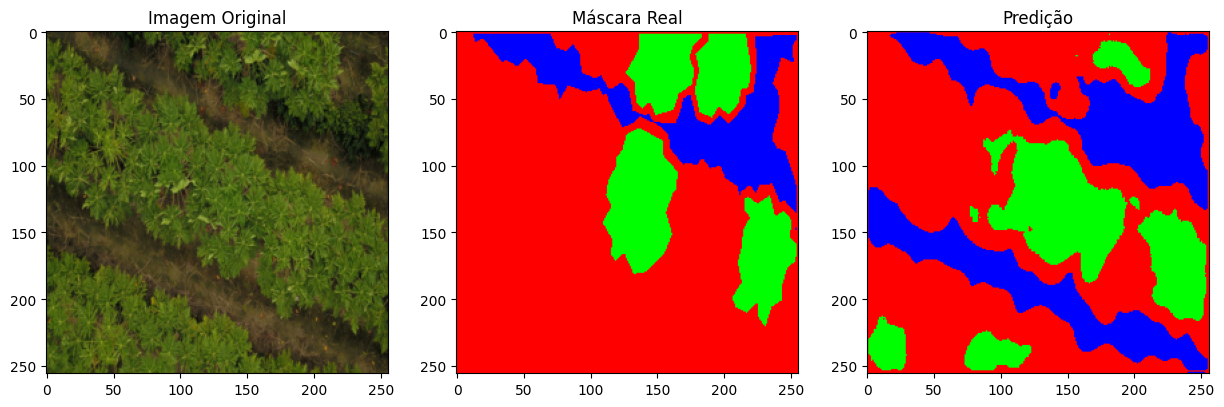

Visualizando e salvando predições para PSPNet...
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


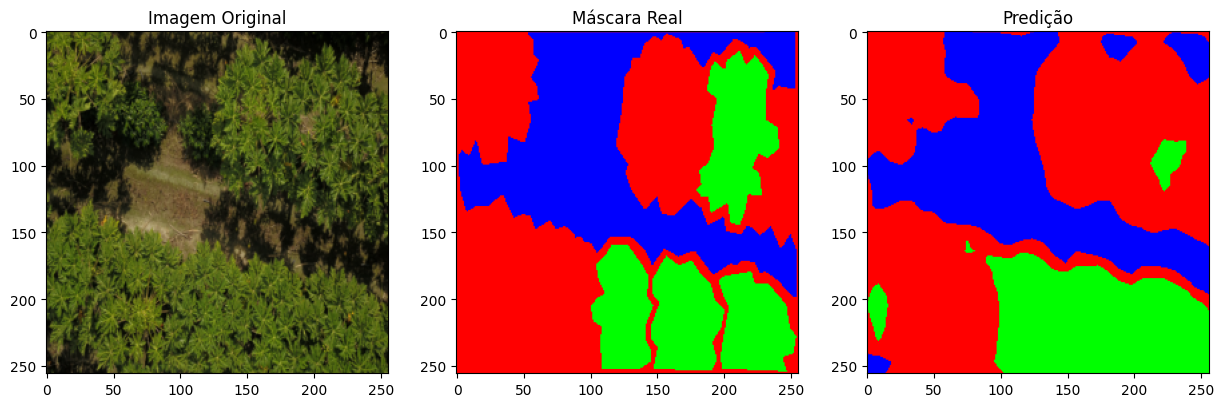

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


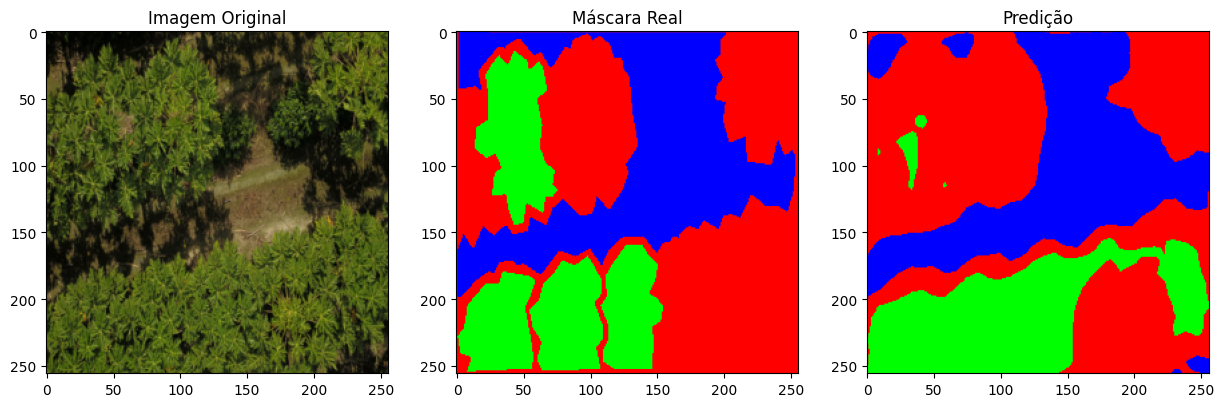

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


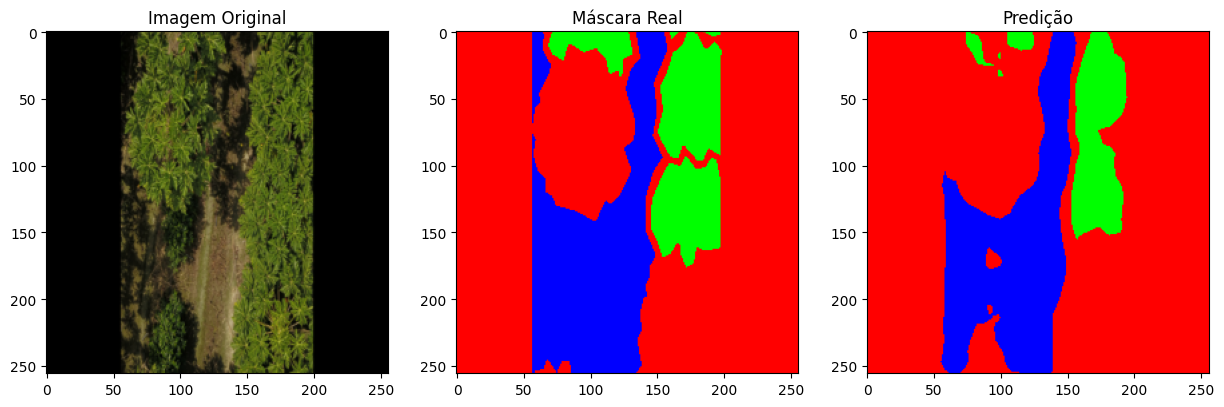

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


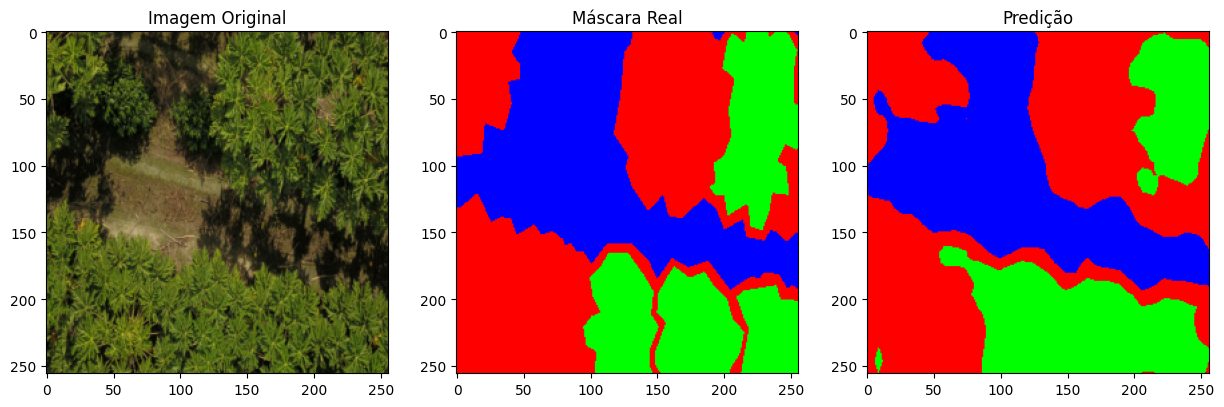

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


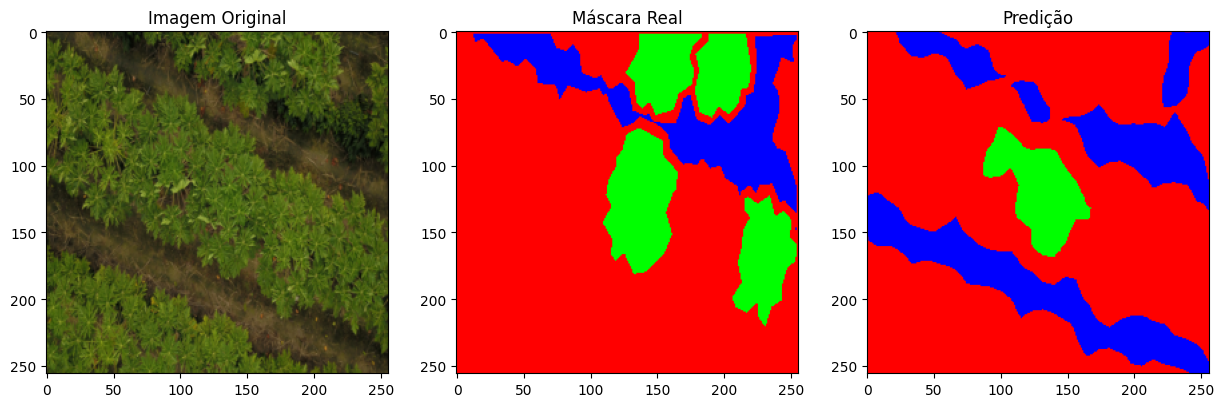

Visualizando e salvando predições para LinkNet...
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


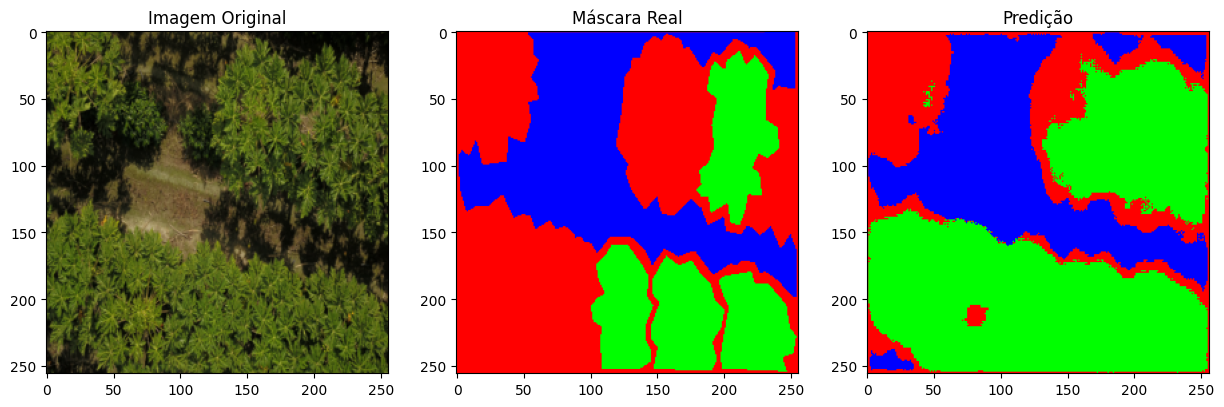

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


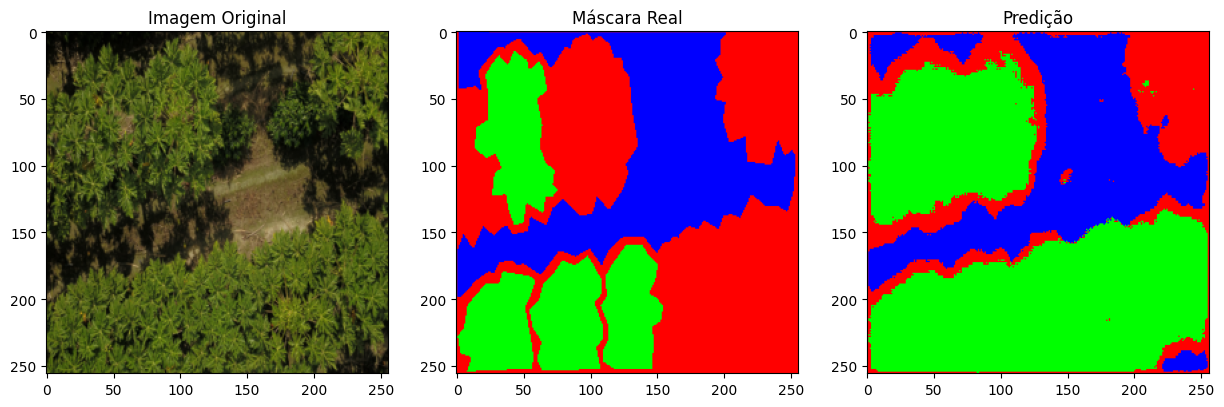

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


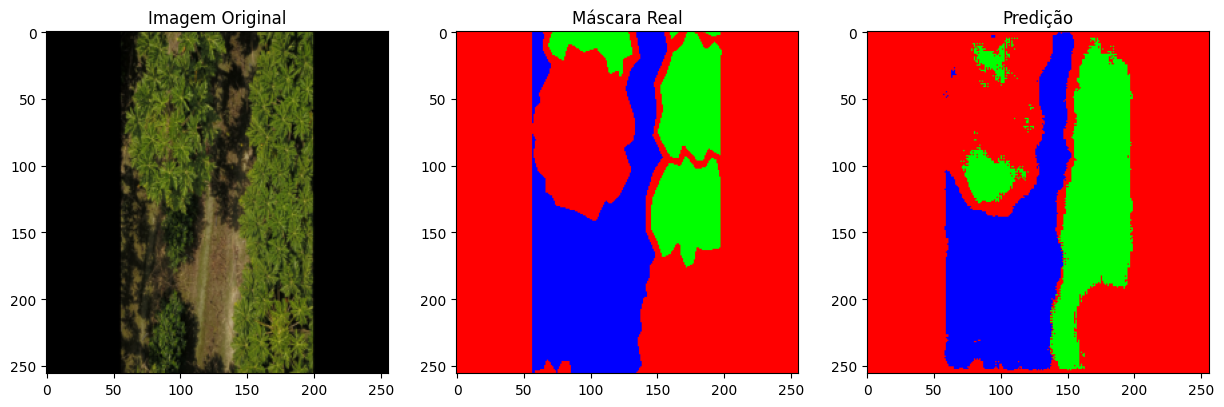

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


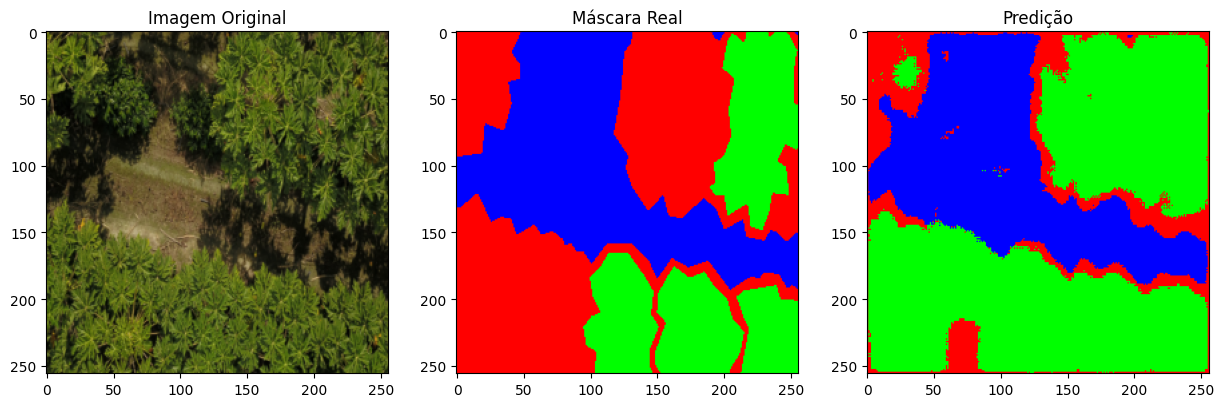

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


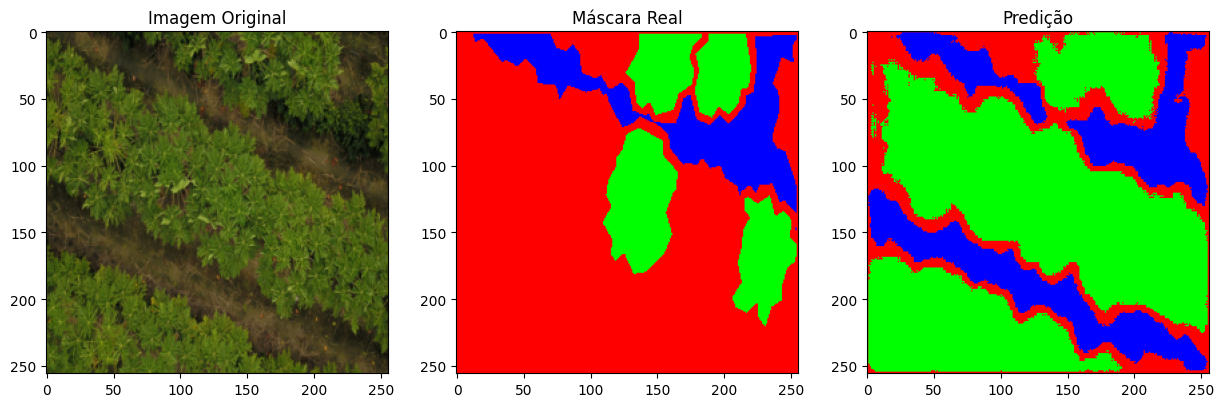

Visualizando e salvando predições para DeepLabV3...
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


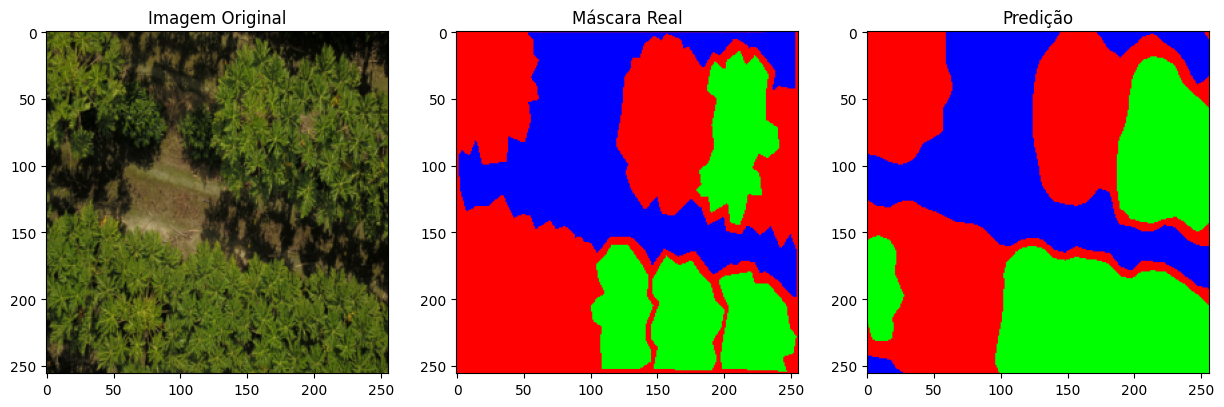

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


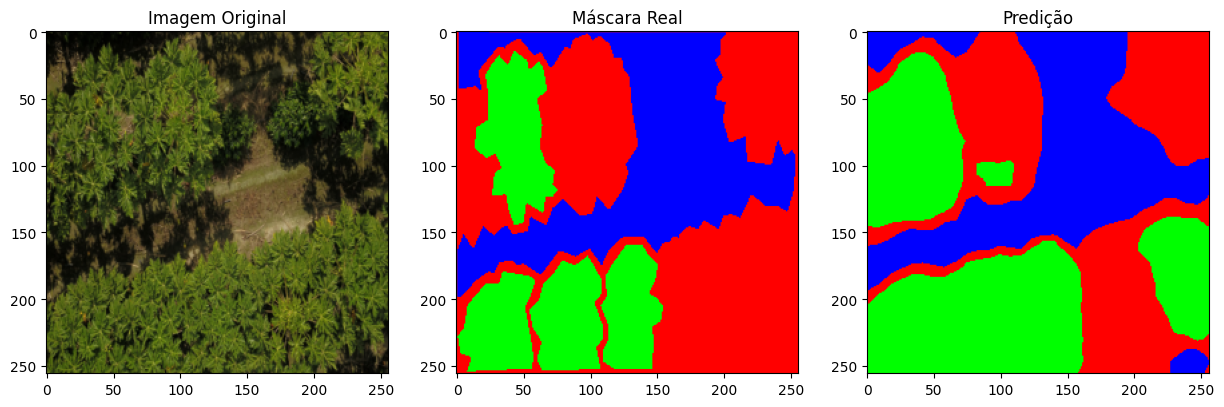

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


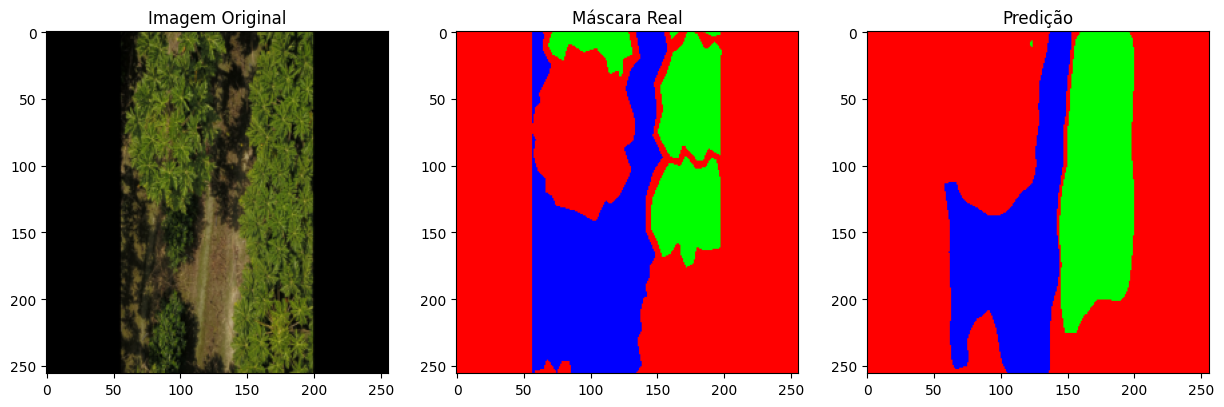

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


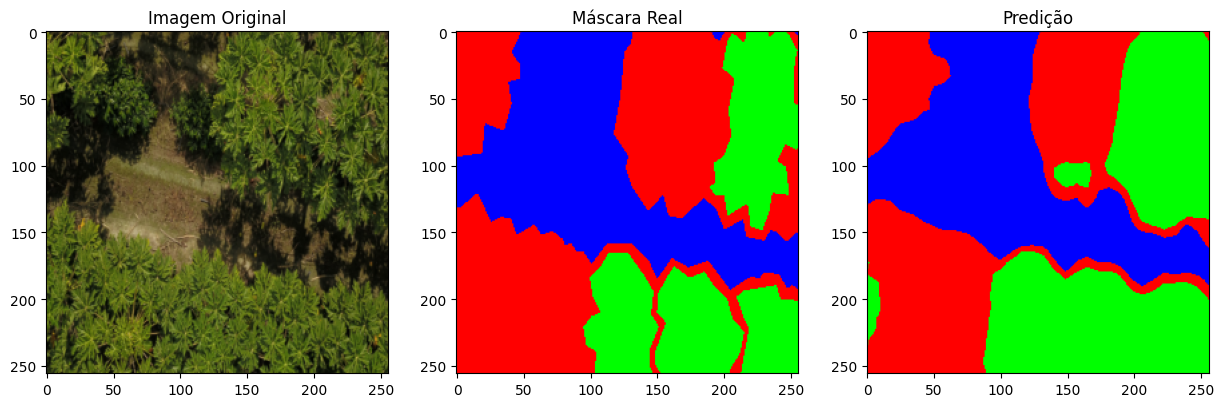

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


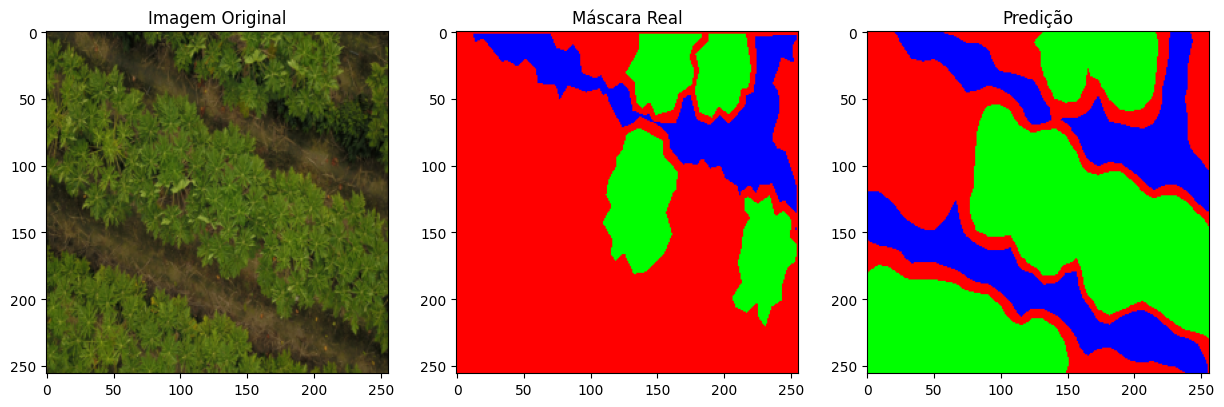

Visualização e salvamento concluídos!


In [47]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

# Diretório para salvar os resultados das imagens
results_dir = "E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/results/images"
os.makedirs(results_dir, exist_ok=True)

# Diretório onde os arquivos do modelo foram salvados
model_dir = "E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/results/data" 

# Função auxiliar para transformar índices de classe em cores RGB
def class_to_rgb(mask_indices):
    mask_rgb = np.zeros((mask_indices.shape[0], mask_indices.shape[1], 3), dtype=np.uint8)
    unique_classes = np.unique(mask_indices)
    print(f"Unique classes in mask: {unique_classes}")  # Log para classes únicas

    for class_index, color in enumerate(CLASS_COLORS.values()):
        mask_rgb[mask_indices == class_index] = color
        print(f"Mapping class {class_index} to color {color}")  # Log para mapeamento
    return mask_rgb

# Função para visualizar e salvar predições
def visualize_and_save_predictions(model, data_loader, device, results_dir, model_name, num_images=5):
    model.eval()
    images_saved = 0

    with torch.no_grad():
        for inputs, masks in data_loader:
            inputs, masks = inputs.to(device), masks.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                images_saved += 1
                if images_saved > num_images:
                    return
                
                # Processamento para visualização
                image = (inputs[i].cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
                
                # Conversão de índices para RGB
                mask = class_to_rgb(masks[i].cpu().numpy())
                prediction = class_to_rgb(preds[i].cpu().numpy())

                # Logs para depuração
                print(f"Input shape: {inputs[i].shape}")
                print(f"Mask shape: {masks[i].shape}")
                print(f"Prediction shape: {preds[i].shape}")

                # Visualização
                plt.figure(figsize=(15, 5))
                
                plt.subplot(1, 3, 1)
                plt.imshow(image)
                plt.title('Imagem Original')

                plt.subplot(1, 3, 2)
                plt.imshow(mask)
                plt.title('Máscara Real')

                plt.subplot(1, 3, 3)
                plt.imshow(prediction)
                plt.title('Predição')

                plt.show()
                
                # Salvar as imagens
                plt.imsave(os.path.join(results_dir, f'{model_name}_input_{images_saved}.png'), image)
                plt.imsave(os.path.join(results_dir, f'{model_name}_mask_{images_saved}.png'), mask)
                plt.imsave(os.path.join(results_dir, f'{model_name}_prediction_{images_saved}.png'), prediction)

# Executar para cada modelo
for model_name, model in models.items():
    print(f"Visualizando e salvando predições para {model_name}...")
    
    trained_model = model
    trained_model_path = os.path.join(model_dir, f'{model_name}_best.pth')
    trained_model.load_state_dict(torch.load(trained_model_path))
    trained_model.to(device)
    
    visualize_and_save_predictions(trained_model, test_loader, device, results_dir, model_name, num_images=5)

print("Visualização e salvamento concluídos!")